In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
import numpy as np

dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Starting get_indices with 16 patches ...
Processed patch 4/16 in 0.03 sec
Processed patch 8/16 in 0.03 sec
Processed patch 12/16 in 0.03 sec
Processed patch 16/16 in 0.03 sec
get_indices completed in 0.44 sec
stacked_tensor shape: torch.Size([16, 3896, 4])


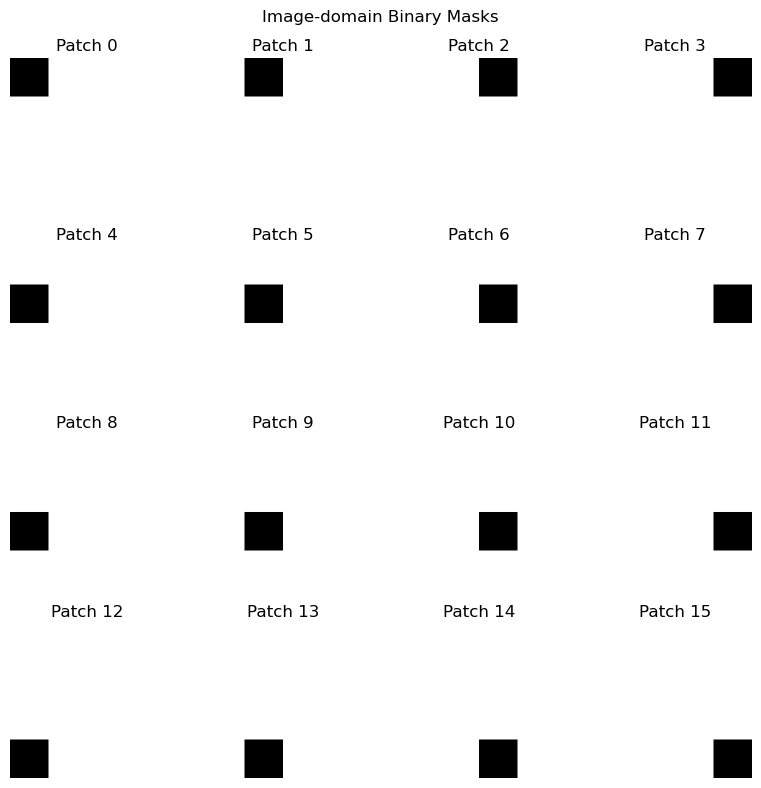

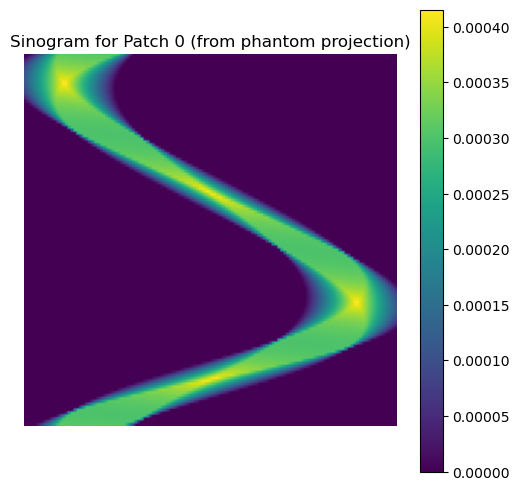

sino_input shape: torch.Size([32, 1, 128, 128])
kernel_input shape: torch.Size([32, 1, 128, 128])
stacked_indices shape: torch.Size([16, 3896, 4])
Output sinogram shape: torch.Size([32, 1, 128, 128])


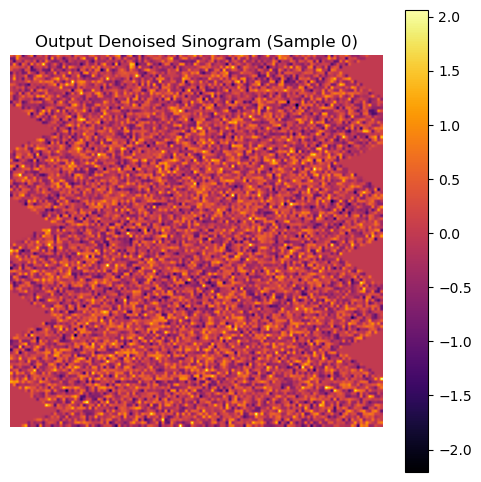

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import odl
import odlpet
from odl.contrib.torch import OperatorModule
from odl.contrib import fom
import time
import warnings
warnings.filterwarnings('ignore')

# ---------------------------
# Unified configuration parameter management
# ---------------------------
config = {
    'image_size': 128,        # Image domain size 128x128
    'patch_size': 32,         # Patch size 32x32 (Thus, a total of (128/32)^2 = 16 patches)
    'num_angles': 128,        # Number of projection angles, determining the number of columns in the sinogram
    'num_detectors': 128,     # Number of detectors, determining the number of rows in the sinogram
    'src_radius': 500,        # Distance from the X-ray source to the center
    'det_radius': 500,        # Distance from the detector to the center
    'mu_water': 0.02          # Attenuation coefficient
}

# ---------------------------
# ODL setup based on parameters from config
# ---------------------------
size = config['image_size']
# The domain coordinate range is fixed at [-128,-128] to [128,128] (adjust according to actual needs)
space = odl.uniform_discr([-128, -128], [128, 128], [size, size],
                           dtype='float32', weighting=1.0)
angle_partition = odl.uniform_partition(0, 2 * np.pi, config['num_angles'])
detector_partition = odl.uniform_partition(-360, 360, config['num_detectors'])
geometry = odl.tomo.FanBeamGeometry(angle_partition, detector_partition, 
                                     src_radius=config['src_radius'], 
                                     det_radius=config['det_radius'])
ray_transform = odl.tomo.RayTransform(space, geometry)
opnorm = odl.power_method_opnorm(ray_transform)
operator = (1 / opnorm) * ray_transform
pseudoinverse = odl.tomo.fbp_op(ray_transform, filter_type='Hann', frequency_scaling=0.45)
mu_water = config['mu_water']

# ---------------------------
# get_indices function: Generate binary masks, sinogram projections, and indices
# ---------------------------
def get_indices(patch_size, s=0, dev='cuda'):
    """
    For an image-domain size of config['image_size'] x config['image_size'],
    patch_size: (height, width) e.g., (32,32)
    s: Threshold, set to 0
    
    Returns:
      stacked_tensor: Tensor [num_patches, max_length, 4], padded indices
      indices: list, each element is the original index tensor (N,4) for a patch (format [0,0,row,col])
      images: np.array, binary masks of each patch in the image domain, shape [num_patches, image_size, image_size]
      sinos: np.array, corresponding sinogram projections for each patch, shape [num_patches, num_detectors, num_angles]
    """
    image_shape = (config['image_size'], config['image_size'])
    if image_shape[0] % patch_size[0] != 0 or image_shape[1] % patch_size[1] != 0:
        raise ValueError("Image dimensions must be divisible by the patch size.")
    
    num_patches_grid = (image_shape[0] // patch_size[0], image_shape[1] // patch_size[1])
    num_patches = num_patches_grid[0] * num_patches_grid[1]
    
    images = np.zeros((num_patches, image_shape[0], image_shape[1]))
    # Sinogram size is determined by the number of detectors and angles
    sinos = np.zeros((num_patches, config['num_detectors'], config['num_angles']))
    indices = []
    
    print(f"Starting get_indices with {num_patches} patches ...")
    start_total = time.time()
    for k in range(num_patches):
        start_patch = time.time()
        i = k // num_patches_grid[1]
        j = k % num_patches_grid[1]
        # Set the current patch region to 1
        images[k, i*patch_size[0]:(i+1)*patch_size[0], j*patch_size[1]:(j+1)*patch_size[1]] = 1
        
        phantom = space.element(images[k])
        phantom /= 1000.0
        data = ray_transform(phantom)
        data = np.exp(-data * mu_water)
        log_data = np.log(data) * (-1 / mu_water) * (1 / opnorm)
        sinos[k] = log_data
        
        # Select pixel indices greater than threshold s (extract row, col), expand the first two dimensions to 0
        index = (torch.tensor(log_data) > s).nonzero()  # shape [N, 2]
        index = torch.cat([torch.zeros(index.shape[0], 2, dtype=torch.long), index], dim=1)
        indices.append(index)
        
        end_patch = time.time()
        if (k+1) % 4 == 0 or k == num_patches - 1:
            print(f"Processed patch {k+1}/{num_patches} in {end_patch - start_patch:.2f} sec")
    end_total = time.time()
    print(f"get_indices completed in {end_total - start_total:.2f} sec")
    
    lengths = [len(idx) for idx in indices]
    max_length = max(lengths)
    padded_tensors = []
    for idx in indices:
        pad_size = max_length - len(idx)
        padded_tensor = F.pad(idx, (0,0, pad_size,0))
        padded_tensors.append(padded_tensor)
    stacked_tensor = torch.stack(padded_tensors)
    print(f"stacked_tensor shape: {stacked_tensor.shape}")
    return stacked_tensor, indices, images, sinos

# Call get_indices (patch_size set to (32,32))
patch_size_tuple = (config['patch_size'], config['patch_size'])
stacked_indices, indices_list, images_mask, sinos_phantom = get_indices(patch_size_tuple, s=0, dev='cuda')

# Visualize all image-domain binary mask patches (16 in total)
num_patches = images_mask.shape[0]
fig, axes = plt.subplots(4, 4, figsize=(8,8))
for idx in range(num_patches):
    ax = axes[idx//4, idx%4]
    ax.imshow(images_mask[idx], cmap='binary')
    ax.set_title(f"Patch {idx}")
    ax.axis('off')
plt.suptitle("Image-domain Binary Masks")
plt.tight_layout()
plt.show()

# Visualize the sinogram projection of the first patch (should show corresponding curved stripes)
plt.figure(figsize=(6,6))
plt.imshow(sinos_phantom[0], cmap='viridis')
plt.title("Sinogram for Patch 0 (from phantom projection)")
plt.colorbar()
plt.axis('off')
plt.show()

class SelfAttentionBlock(nn.Module):
    """
    一个简单的自注意力层：
    - Q, K, V 全来自 sinogram tokens
    - 之后加残差和 MLP
    """
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super(SelfAttentionBlock, self).__init__()
        self.mha = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 2),
            nn.GELU(),
            nn.Linear(embed_dim * 2, embed_dim)
        )
        self.norm2 = nn.LayerNorm(embed_dim)
    
    def forward(self, x):
        # x: [B, num_patches, embed_dim]，自注意力 -> (Q=K=V=x)
        attn_output, attn_weights = self.mha(
            query=x,
            key=x,
            value=x
        )
        # 残差 + LayerNorm
        x = self.norm1(x + attn_output)
        # MLP
        x2 = self.mlp(x)
        x = self.norm2(x + x2)
        return x, attn_weights

class CrossAttentionBlock(nn.Module):
    """
    A simple cross-attention layer:
    - Query comes from sinogram tokens
    - Key, Value come from kernel tokens
    - Then perform residual connection and MLP
    """
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super(CrossAttentionBlock, self).__init__()
        self.mha = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, embed_dim*2),
            nn.GELU(),
            nn.Linear(embed_dim*2, embed_dim)
        )
        self.norm2 = nn.LayerNorm(embed_dim)
    
    def forward(self, sinogram_tokens, kernel_tokens):
        # sinogram_tokens: [B, num_patches, embed_dim] (Query)
        # kernel_tokens:   [B, num_patches, embed_dim] (Key, Value)
        # MultiheadAttention requires (N, S, E), when batch_first=True it is (N, B, E)
        attn_output, attn_weights = self.mha(
            query=sinogram_tokens,
            key=kernel_tokens,
            value=kernel_tokens
        )
        # Residual connection + LayerNorm
        x = self.norm1(sinogram_tokens + attn_output)
        # MLP
        x2 = self.mlp(x)
        x = self.norm2(x + x2)
        return x, attn_weights

# ---------------------------
# Model Definition: DualBranchTransformerModel
# ---------------------------
class DualBranchTransformerModel(nn.Module):
    def __init__(self, indices, embed_dim=128, num_heads=4, num_layers=2, dropout=0.1):
        super(DualBranchTransformerModel, self).__init__()
        self.indices = indices
        self.num_patches = indices.shape[0]
        self.max_length = indices.shape[1]
        
        # Sinogram token embedding
        self.sino_linear = nn.Linear(self.max_length, embed_dim)
        
        # Kernel token embedding
        self.kernel_patch_embed = nn.Conv2d(1, embed_dim, kernel_size=config['patch_size'], stride=config['patch_size'])
        self.kernel_pos_embed = nn.Parameter(torch.zeros(1, self.num_patches, embed_dim))
        nn.init.trunc_normal_(self.kernel_pos_embed, std=0.02)
        
        # Multiple cross-attention layers
        self.cross_attn_blocks = nn.ModuleList([
            CrossAttentionBlock(embed_dim, num_heads, dropout=dropout)
            for _ in range(num_layers)
        ])
        
        # Multiple self-attention layers (allow sinogram tokens to interact)
        self.self_attn_blocks = nn.ModuleList([
            SelfAttentionBlock(embed_dim, num_heads, dropout=dropout)
            for _ in range(num_layers)
        ])
        
        # Decoder
        self.sino_decoder = nn.Linear(embed_dim, self.max_length)
    
    def forward(self, sino, kernel):
        B = sino.shape[0]
        tokens = []
        for b in range(B):
            sino_b = sino[b, 0]  # [H_s, W_s]
            patch_tokens = []
            for p in range(self.num_patches):
                idx = self.indices[p]
                rows = idx[:, 2]
                cols = idx[:, 3]
                patch_vals = sino_b[rows, cols]
                patch_tokens.append(patch_vals)
            patch_tokens = torch.stack(patch_tokens, dim=0)
            tokens.append(patch_tokens)
        # Shape: [B, num_patches, max_length]
        tokens = torch.stack(tokens, dim=0)
        
        # Sinogram tokens
        sino_tokens = self.sino_linear(tokens)  # [B, num_patches, embed_dim]
        
        # Kernel tokens
        kernel_emb = self.kernel_patch_embed(kernel)  # [B, embed_dim, 4,4]
        kernel_emb = kernel_emb.flatten(2).transpose(1,2)  # [B, num_patches, embed_dim]
        kernel_emb = kernel_emb + self.kernel_pos_embed
        
        # First apply multiple cross-attention layers (sino_tokens <-> kernel_tokens)
        for block in self.cross_attn_blocks:
            sino_tokens, attn_w = block(sino_tokens, kernel_emb)
        
        # Then apply multiple self-attention layers (sino_tokens interact among themselves)
        for block in self.self_attn_blocks:
            sino_tokens, attn_w2 = block(sino_tokens)
        
        # Decode
        decoded_tokens = self.sino_decoder(sino_tokens)  # [B, num_patches, max_length]
        
        # Write back
        sino_out = sino.clone()
        for b in range(B):
            for p in range(self.num_patches):
                idx = self.indices[p]
                rows = idx[:, 2]
                cols = idx[:, 3]
                sino_out[b, 0, rows, cols] = decoded_tokens[b, p]
        return sino_out


# ---------------------------
# Test Code: Testing with a saved dataset
# ---------------------------
# Load the saved dataset (all image sizes are 128x128)
dataset_dict = torch.load("pet_ct_dataset_test_odl.pt")
pet_sinograms_noised_cpu = dataset_dict['pet_sinograms_noised']  # List, each element has shape (128,128)
kernels_ct_cpu = dataset_dict['kernels_ct']                      # List, each element has shape (128,128)

# Convert list to tensor and add channel dimension: Final shape [N, 1, 128, 128]
sino_input = torch.stack([x for x in pet_sinograms_noised_cpu], dim=0).unsqueeze(1)
kernel_input = torch.stack([x for x in kernels_ct_cpu], dim=0).unsqueeze(1)
print("sino_input shape:", sino_input.shape)
print("kernel_input shape:", kernel_input.shape)

sino_input = sino_input.to(dev)
kernel_input = kernel_input.to(dev)

print("stacked_indices shape:", stacked_indices.shape)

# Create model instance
model = DualBranchTransformerModel(indices=stacked_indices, embed_dim=128, num_heads=4, num_layers=2, dropout=0.1)
model = model.to(dev)

# Forward pass
sino_out = model(sino_input, kernel_input)
print("Output sinogram shape:", sino_out.shape)

# Visualize the output of the first sample
out_np = sino_out[0, 0].detach().cpu().numpy()
plt.figure(figsize=(6,6))
plt.imshow(out_np, cmap='inferno')
plt.title("Output Denoised Sinogram (Sample 0)")
plt.colorbar()
plt.axis('off')
plt.show()


Epoch [1/50], Loss: 1162.9434
Epoch [2/50], Loss: 1081.8329
Epoch [3/50], Loss: 1000.7611
Epoch [4/50], Loss: 925.0213
Epoch [5/50], Loss: 853.2138
Epoch [6/50], Loss: 784.8603
Epoch [7/50], Loss: 723.8928
Epoch [8/50], Loss: 668.5064
Epoch [9/50], Loss: 617.0167
Epoch [10/50], Loss: 570.7568


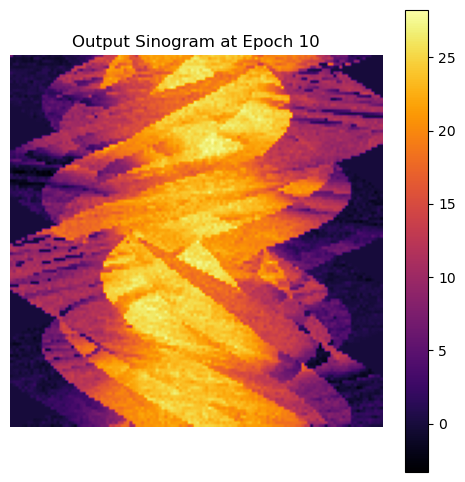

Epoch [11/50], Loss: 528.3363
Epoch [12/50], Loss: 490.8695
Epoch [13/50], Loss: 456.3180
Epoch [14/50], Loss: 424.4974
Epoch [15/50], Loss: 395.7254
Epoch [16/50], Loss: 370.5202
Epoch [17/50], Loss: 346.6787
Epoch [18/50], Loss: 325.1956
Epoch [19/50], Loss: 305.3920
Epoch [20/50], Loss: 287.7798


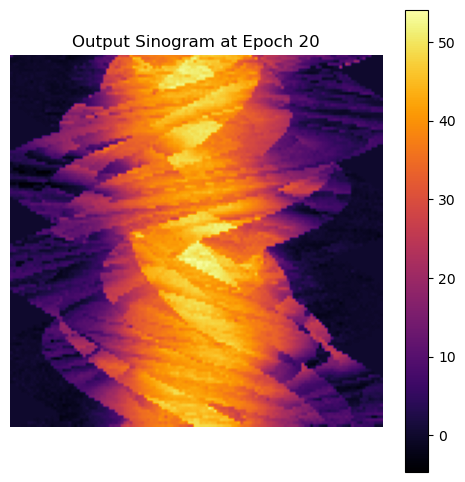

Epoch [21/50], Loss: 271.1802
Epoch [22/50], Loss: 256.2292
Epoch [23/50], Loss: 242.8760
Epoch [24/50], Loss: 230.4660
Epoch [25/50], Loss: 218.6893
Epoch [26/50], Loss: 207.7981
Epoch [27/50], Loss: 198.2528
Epoch [28/50], Loss: 189.2843
Epoch [29/50], Loss: 180.7462
Epoch [30/50], Loss: 173.1743


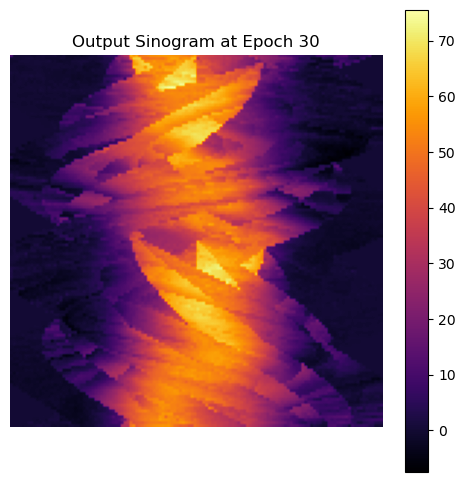

Epoch [31/50], Loss: 165.6348
Epoch [32/50], Loss: 158.7060
Epoch [33/50], Loss: 152.7015
Epoch [34/50], Loss: 146.6347
Epoch [35/50], Loss: 140.3153
Epoch [36/50], Loss: 134.8129
Epoch [37/50], Loss: 129.4125
Epoch [38/50], Loss: 124.1097
Epoch [39/50], Loss: 119.3462
Epoch [40/50], Loss: 113.7358


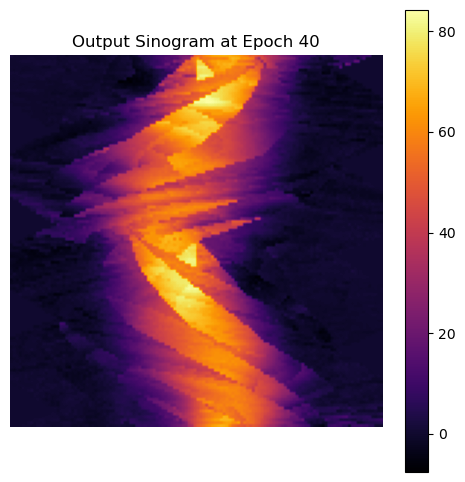

Epoch [41/50], Loss: 108.8040
Epoch [42/50], Loss: 103.9990
Epoch [43/50], Loss: 99.3230
Epoch [44/50], Loss: 95.2204
Epoch [45/50], Loss: 90.7353
Epoch [46/50], Loss: 86.5829
Epoch [47/50], Loss: 82.3921
Epoch [48/50], Loss: 78.7017
Epoch [49/50], Loss: 75.5984
Epoch [50/50], Loss: 71.9024


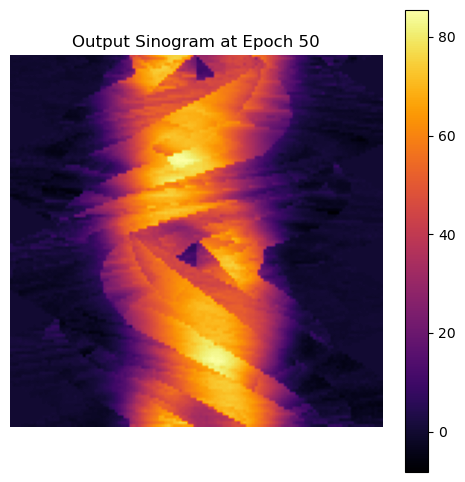

Training completed!


In [3]:
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

training_config ={
    'lr': 1e-4,               # Learning rate
    'num_epochs': 50,         # Number of training epochs
    'batch_size': 32,         # Batch size
    'ssim_weight': 0.5        # SSIM loss weight
}

# ---------------------------
# Custom Dataset: PETCTTrainDataset
# ---------------------------
class PETCTTrainDataset(Dataset):
    def __init__(self, dataset_dict):
        """
        dataset_dict: Contains the following keys:
            'pet_sinograms_noised': list of PET sinograms (each [128,128])
            'pet_sinograms_clean': list of clean PET sinograms (each [128,128])
            'kernels_ct': list of CT-derived kernels (each [128,128])
        """
        self.pet_sinograms_noised = dataset_dict['pet_sinograms_noised']
        self.pet_sinograms_clean = dataset_dict['pet_sinograms_clean']
        self.kernels_ct = dataset_dict['kernels_ct']
        
    def __len__(self):
        return len(self.pet_sinograms_noised)
    
    def __getitem__(self, idx):
        # Add channel dimension, changing shape to [1,128,128]
        sino_noised = self.pet_sinograms_noised[idx].unsqueeze(0)
        sino_clean  = self.pet_sinograms_clean[idx].unsqueeze(0)
        kernel      = self.kernels_ct[idx].unsqueeze(0)
        return sino_noised, sino_clean, kernel

# ---------------------------
# Define SSIM Loss (Skip if already defined earlier)
# ---------------------------
def gaussian(window_size, sigma):
    gauss = torch.Tensor([np.exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
    return window

def ssim(img1, img2, window_size=11, size_average=True):
    channel = img1.size(1)
    window = create_window(window_size, channel).to(img1.device)
    
    mu1 = F.conv2d(img1, window, padding=window_size//2, groups=channel)
    mu2 = F.conv2d(img2, window, padding=window_size//2, groups=channel)
    
    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2
    
    sigma1_sq = F.conv2d(img1*img1, window, padding=window_size//2, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding=window_size//2, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding=window_size//2, groups=channel) - mu1_mu2
    
    C1 = 0.01**2
    C2 = 0.03**2
    
    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2)) / ((mu1_sq+mu2_sq+C1)*(sigma1_sq+sigma2_sq+C2))
    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

class SSIMLoss(nn.Module):
    def __init__(self, window_size=11, size_average=True):
        super(SSIMLoss, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
    def forward(self, img1, img2):
        return 1 - ssim(img1, img2, self.window_size, self.size_average)

# ---------------------------
# Define Mixed Loss Function: MSE + SSIM
# ---------------------------
mse_loss = nn.MSELoss()
ssim_loss_fn = SSIMLoss(window_size=11, size_average=True)

def mixed_loss(output, target, ssim_weight=0.5):
    loss_mse = mse_loss(output, target)
    loss_ssim = ssim_loss_fn(output, target)
    return loss_mse + ssim_weight * loss_ssim

# ---------------------------
# Create Dataset and DataLoader
# ---------------------------
# Load the saved dataset (previously saved as "pet_ct_dataset_test_odl.pt")
dataset_dict = torch.load("pet_ct_dataset_odl.pt")
train_dataset = PETCTTrainDataset(dataset_dict)
train_loader = DataLoader(train_dataset, batch_size=training_config['batch_size'], shuffle=True)

# ---------------------------
# Create Model Instance (Previously defined DualBranchTransformerModel) and Move to Device
# ---------------------------
model = DualBranchTransformerModel(indices=stacked_indices, embed_dim=128, num_heads=4, num_layers=2, dropout=0.1)
model = model.to(dev)

# ---------------------------
# Define Optimizer: Adam
# ---------------------------
optimizer = optim.Adam(model.parameters(), lr=training_config['lr'])

# ---------------------------
# Training Loop
# ---------------------------
num_epochs = training_config['num_epochs']  # Or set as needed
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, (sino_noised, sino_clean, kernel) in enumerate(train_loader):
        sino_noised = sino_noised.to(dev)
        sino_clean = sino_clean.to(dev)
        kernel = kernel.to(dev)
        
        optimizer.zero_grad()
        outputs = model(sino_noised, kernel)
        loss = mixed_loss(outputs, sino_clean, ssim_weight=training_config['ssim_weight'])
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
    
    # Visualize results every 10 epochs
    if (epoch+1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            sample_output = model(sino_noised, kernel)
        plt.figure(figsize=(6,6))
        plt.imshow(sample_output[0,0].detach().cpu().numpy(), cmap='inferno')
        plt.title(f"Output Sinogram at Epoch {epoch+1}")
        plt.colorbar()
        plt.axis('off')
        plt.show()
        model.train()

print("Training completed!")

Epoch [51/100], Loss: 68.8494
Epoch [52/100], Loss: 65.7591
Epoch [53/100], Loss: 63.0945
Epoch [54/100], Loss: 60.5494
Epoch [55/100], Loss: 57.5507
Epoch [56/100], Loss: 55.3045
Epoch [57/100], Loss: 52.9812
Epoch [58/100], Loss: 50.8613
Epoch [59/100], Loss: 48.7666
Epoch [60/100], Loss: 47.3630


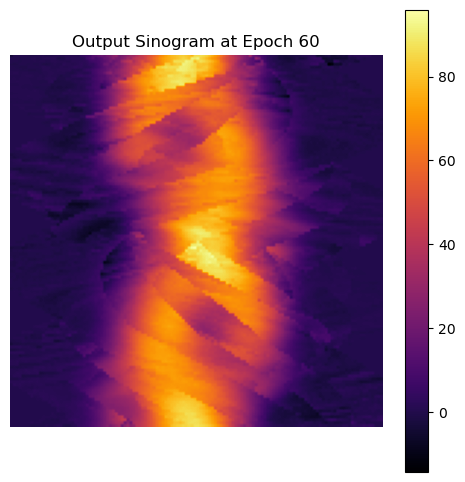

Epoch [61/100], Loss: 45.2245
Epoch [62/100], Loss: 43.7376
Epoch [63/100], Loss: 42.0874
Epoch [64/100], Loss: 40.3733
Epoch [65/100], Loss: 39.1520
Epoch [66/100], Loss: 37.7387
Epoch [67/100], Loss: 36.2413
Epoch [68/100], Loss: 34.9736
Epoch [69/100], Loss: 34.4040
Epoch [70/100], Loss: 32.8825


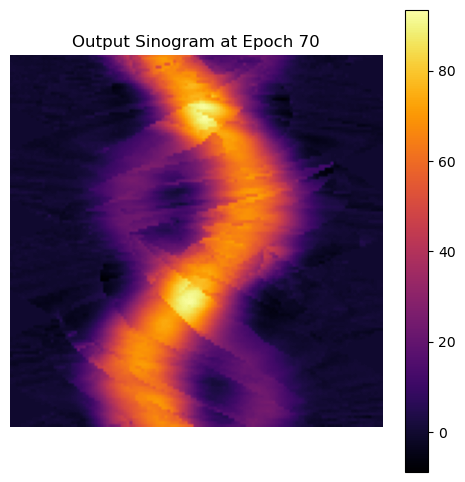

Epoch [71/100], Loss: 32.2793
Epoch [72/100], Loss: 31.2832
Epoch [73/100], Loss: 30.3189
Epoch [74/100], Loss: 29.4430
Epoch [75/100], Loss: 28.7880
Epoch [76/100], Loss: 27.9475
Epoch [77/100], Loss: 27.3630
Epoch [78/100], Loss: 26.6941
Epoch [79/100], Loss: 25.9683
Epoch [80/100], Loss: 25.4748


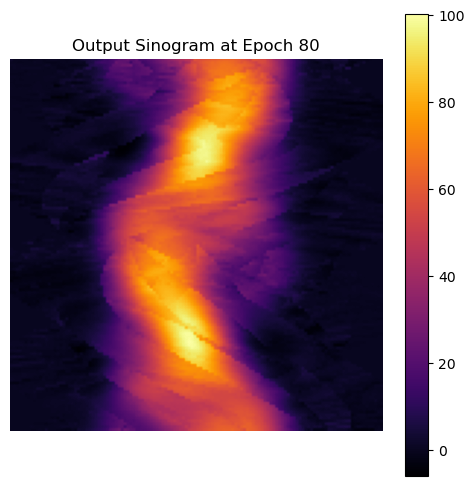

Epoch [81/100], Loss: 25.5239
Epoch [82/100], Loss: 24.1731
Epoch [83/100], Loss: 23.6883
Epoch [84/100], Loss: 23.5984
Epoch [85/100], Loss: 22.9139
Epoch [86/100], Loss: 22.6024
Epoch [87/100], Loss: 22.2108
Epoch [88/100], Loss: 22.0609
Epoch [89/100], Loss: 21.5033
Epoch [90/100], Loss: 21.1703


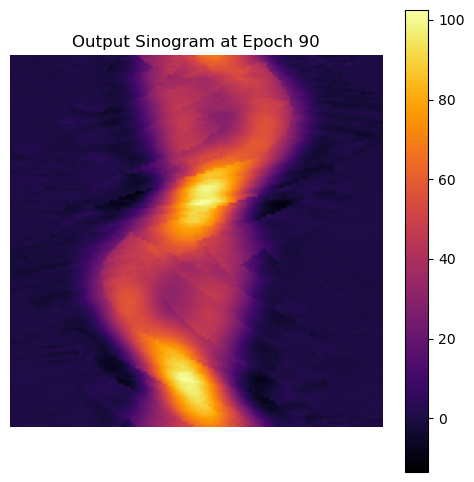

Epoch [91/100], Loss: 20.7376
Epoch [92/100], Loss: 20.3582
Epoch [93/100], Loss: 20.1248
Epoch [94/100], Loss: 20.0382
Epoch [95/100], Loss: 19.7326
Epoch [96/100], Loss: 19.1791
Epoch [97/100], Loss: 18.8696
Epoch [98/100], Loss: 18.8668
Epoch [99/100], Loss: 18.7292
Epoch [100/100], Loss: 18.2699


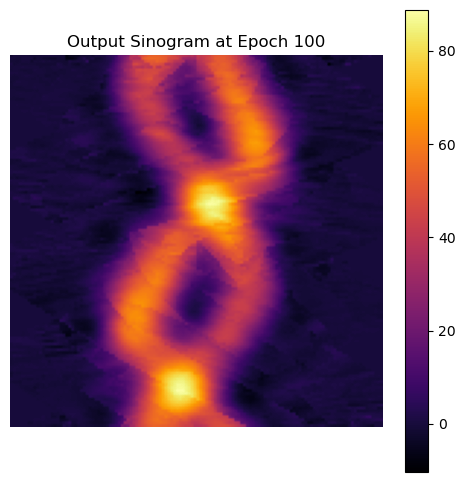

Training completed!


In [4]:
start_epoch = 50
total_epochs = 100
for epoch in range(start_epoch, total_epochs):
    running_loss = 0.0
    for batch_idx, (sino_noised, sino_clean, kernel) in enumerate(train_loader):
        sino_noised = sino_noised.to(dev)
        sino_clean = sino_clean.to(dev)
        kernel = kernel.to(dev)
        
        optimizer.zero_grad()
        outputs = model(sino_noised, kernel)
        loss = mixed_loss(outputs, sino_clean, ssim_weight=training_config['ssim_weight'])
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{total_epochs}], Loss: {avg_loss:.4f}")
    
    if (epoch+1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            sample_output = model(sino_noised, kernel)
        plt.figure(figsize=(6,6))
        plt.imshow(sample_output[0,0].detach().cpu().numpy(), cmap='inferno')
        plt.title(f"Output Sinogram at Epoch {epoch+1}")
        plt.colorbar()
        plt.axis('off')
        plt.show()
        model.train()

print("Training completed!")

Validation PSNR: 27.50, SSIM: 0.6778


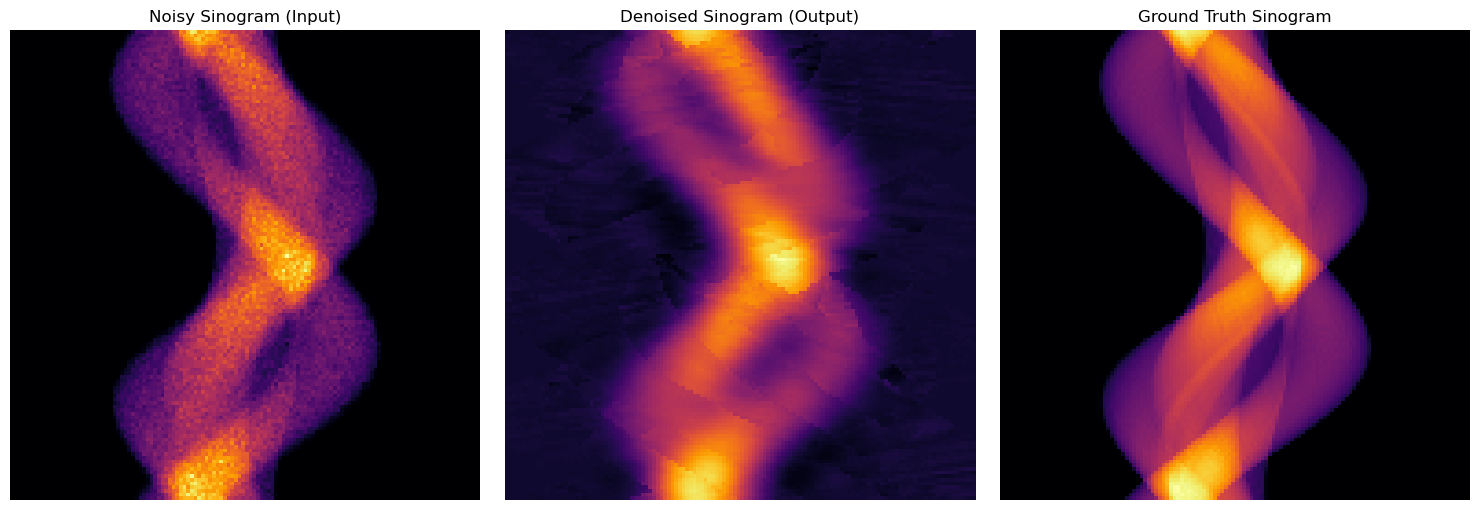

DualBranchTransformerModel(
  (sino_linear): Linear(in_features=3896, out_features=128, bias=True)
  (kernel_patch_embed): Conv2d(1, 128, kernel_size=(32, 32), stride=(32, 32))
  (cross_attn_blocks): ModuleList(
    (0-1): 2 x CrossAttentionBlock(
      (mha): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=128, out_features=256, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=256, out_features=128, bias=True)
      )
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
  )
  (self_attn_blocks): ModuleList(
    (0-1): 2 x SelfAttentionBlock(
      (mha): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (norm1): LayerNorm((128,), eps=1e-05, elementwis

In [5]:
def validate(model, val_loader):
    model.eval()
    total_psnr = 0.0
    total_ssim = 0.0
    count = 0
    with torch.no_grad():
        for sino_noised, sino_clean, kernel in val_loader:
            sino_noised = sino_noised.to(dev)
            sino_clean = sino_clean.to(dev)
            kernel = kernel.to(dev)
            output = model(sino_noised, kernel)
            # Compute metrics: PSNR and SSIM, assuming you have implemented fom.psnr and fom.ssim
            for i in range(output.size(0)):
                out_np = output[i,0].detach().cpu().numpy()
                target_np = sino_clean[i,0].detach().cpu().numpy()
                psnr_val = fom.psnr(out_np, target_np)
                ssim_val = fom.ssim(out_np, target_np)
                total_psnr += psnr_val
                total_ssim += ssim_val
                count += 1
        avg_psnr = total_psnr / count
        avg_ssim = total_ssim / count
    model.train()
    return avg_psnr, avg_ssim

# Assuming you have split the dataset into train and val, below demonstrates how to use DataLoader for validation:
# For example, using PETCTTrainDataset for validation (you may need a separate validation dataset in practice)
val_dataset = PETCTTrainDataset(dataset_dict)
val_loader = DataLoader(val_dataset, batch_size=training_config['batch_size'], shuffle=False)

# Load a saved model (as shown in the checkpoint loading code above)
# Then perform validation
avg_psnr, avg_ssim = validate(model, val_loader)
print(f"Validation PSNR: {avg_psnr:.2f}, SSIM: {avg_ssim:.4f}")

# Set the model to evaluation mode
model.eval()
with torch.no_grad():
    # Take the first sample from the validation set for visualization
    sample_noised, sample_clean, sample_kernel = val_dataset[0]
    # Add batch dimension: [1, 1, 128, 128]
    sample_noised = sample_noised.unsqueeze(0).to(dev)
    sample_clean  = sample_clean.unsqueeze(0).to(dev)
    sample_kernel = sample_kernel.unsqueeze(0).to(dev)
    
    # Forward pass to get network output
    sample_output = model(sample_noised, sample_kernel)

# Convert to numpy array and remove batch and channel dimensions
noisy_np  = sample_noised[0, 0].detach().cpu().numpy()
output_np = sample_output[0, 0].detach().cpu().numpy()
gt_np     = sample_clean[0, 0].detach().cpu().numpy()

# Create a triptych for display
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(noisy_np, cmap='inferno')
axs[0].set_title("Noisy Sinogram (Input)")
axs[0].axis('off')

axs[1].imshow(output_np, cmap='inferno')
axs[1].set_title("Denoised Sinogram (Output)")
axs[1].axis('off')

axs[2].imshow(gt_np, cmap='inferno')
axs[2].set_title("Ground Truth Sinogram")
axs[2].axis('off')

plt.tight_layout()
plt.show()

# Restore model to training mode (if further training is needed)
model.train()
